# Detecção de Fraudes em Pagamentos - Analise do modelo

### Bibliotecas

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/datasetinf'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from ydata_profiling import ProfileReport
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter

from sklearn.metrics import average_precision_score, mean_absolute_error, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

# check xgboost version
from xgboost import XGBClassifier

import timeit
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/datasetinf/describe.csv
/kaggle/input/datasetinf/PS_20174392719_1491204439457_log.csv
/kaggle/input/datasetinf/paysim_predicted.csv


/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


### Layout

In [1]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16,
    'axes.titlesize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(rc=rc)
sns.set_style("darkgrid")
sns.set_palette("pastel")

### Configurações

In [2]:
#pd.set_option('max_columns', 200)
pd.options.display.max_columns = 200 

# Define um valor maior para a largura máxima das colunas
pd.options.display.max_colwidth = 1000

seed = 42
np.random.seed(seed)

### Funções

In [3]:
def plotbox(column):
    plt.figure(figsize=(4, 4))
    bplots = plt.boxplot(df[column], vert=1)

    # Adicionando Título ao gráfico
    plt.title("Boxplot de" + column, loc="center", fontsize=18)
    plt.xlabel(column)
    plt.ylabel("Valores")

    plt.show()

In [4]:
def format_number(number):
    if number >= 1000:
        return f"{number:.0f}"
    else:
        return f"{number:.2f}"

In [5]:
def aucur(y_test, preds):
    # calculate AUC
    aucur = roc_auc_score(y_test, preds)
    print('AUC: %.3f' % aucur)

    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, preds)

    # plot no skill
    plt.figure(figsize=(4, 3))
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

In [6]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [7]:
def plot_feature_freq(df, feature, top_n=10):
    value_counts = df[feature].value_counts(dropna=True)
    top_values = value_counts.head(top_n)
    other_values_count = value_counts.iloc[top_n:].sum()

    if other_values_count > 0:
        top_values['Outros'] = other_values_count

    total = top_values.sum()

    plt.figure(figsize=(5, 4))
    ax = sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')

    for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        percentage = p.get_height() / total * 100
        ax.annotate('{:.1f}%'.format(percentage), (p.get_x() + p.get_width() / 2., 0),
                    ha='center', va='center', xytext=(0, -40), textcoords='offset points')

    ax.set(xlabel='isFraud', ylabel='Quantidade')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

***
# 1) Definição do problema e objetivo do projeto

## 1.1) Contexto

Apresentamos um conjunto de dados sintético gerado usando o simulador denominado PaySim como uma abordagem para tal problema. PaySim usa dados agregados do conjunto de dados privado para gerar um conjunto de dados sintético que se assemelha à operação normal das transações e injeta comportamento malicioso para avaliar posteriormente o desempenho dos métodos de detecção de fraude.

## 1.2) Sobre o Conteudo

PaySim simula transações de dinheiro móvel com base em uma amostra de transações reais extraídas de um mês de registros financeiros de um serviço de dinheiro móvel implementado em um país africano. Os registos originais foram fornecidos por uma empresa multinacional, fornecedora do serviço financeiro móvel que funciona atualmente em mais de 14 países em todo o mundo.

Este conjunto de dados sintético foi reduzido em 1/4 do conjunto de dados original e foi criado apenas para Kaggle.

## 1.3) Dicionario de dados

In [8]:
dicionario = pd.read_csv('/kaggle/input/datasetinf/describe.csv', delimiter=';', header=None, encoding='latin1', index_col=None)
dicionario

,0,1
0,step,"mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo equivale a 1 hora. Total de passos 744 (simulação de 30 dias)."
1,type,"CASH-IN, CASH-OUT, DÉBITO, PAGAMENTO e TRANSFERÊNCIA."
2,amount,valor da transação em moeda local.
3,nameOrig,cliente que iniciou a transação
4,oldbalanceOrg,saldo inicial antes da transação
5,newbalanceOrig,novo saldo após a transação.
6,nameDest,cliente que é o destinatário da transação
7,oldbalanceDest,destinatário do saldo inicial antes da transação. Observe que não há informações para clientes que iniciam com M (Comerciantes).
8,newbalanceDest,novo destinatário do saldo após a transação. Observe que não há informações para clientes que iniciam com M (Comerciantes).
9,isFraud,"São as transações realizadas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar assumindo o controle das contas dos clientes e tentando esvaziar os fundos transferindo para outra conta e depois sacando do sistema."


***
# 2) Coleta e preparação dos dados

## 2.1) Coleta dos dados - dataset

In [9]:
# treinamento
df_orig = pd.read_csv('/kaggle/input/datasetinf/PS_20174392719_1491204439457_log.csv')

# isFlaggedFraud foi excluido pois o modelo pode usar esta coluna como referencia para prever fraudes
df_orig = df_orig.drop(['isFlaggedFraud'],axis=1)

print(df_orig.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0


## 2.2) Coleta dos dados - Dados previstos

In [10]:
# treinamento
df = pd.read_csv('/kaggle/input/datasetinf/paysim_predicted.csv')
print(df.head())

   step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  preds
0   329   PAYMENT   30581.27   C304280890           0.00            0.00  M1794866928            0.00            0.00        0      0
1   398   PAYMENT   22495.13  C1506061797      134850.69       112355.56  M1388898462            0.00            0.00        0      0
2   163   PAYMENT    8656.01  C1123454499           0.00            0.00   M797125081            0.00            0.00        0      0
3   204  TRANSFER  129428.54  C1521052110       46621.00            0.00  C2057278308      2685396.72      2814825.26        0      0
4    35   PAYMENT    9187.37   C581384693       13236.00         4048.63   M990605534            0.00            0.00        0      0


***
# 3) Análise exploratória dos dados reais e previstos

## 3.1) Total de transações

In [22]:
print('Total de Transações:',df.shape[0])

Total de Transações: 4453834


## 3.2) Começamos a análise procurando saber a quantidade de transações com fraude e sem fraude

In [23]:
print('Transações fraudulentas:', (df.isFraud == 1).sum(), '\nTransações não fraudulentas:', (df.isFraud == 0).sum())

Transações fraudulentas: 5749 
Transações não fraudulentas: 4448085


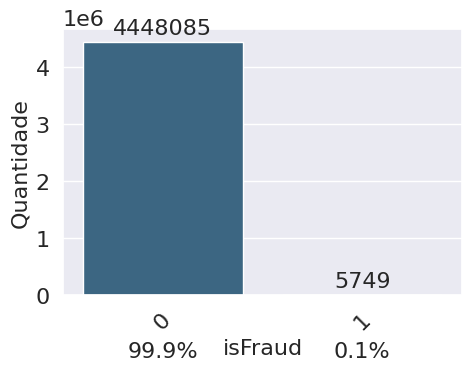

In [24]:
plot_feature_freq(df, 'isFraud')

## 3.2) Transações que o modelo classificou como fraudulentas

In [25]:
print('Transações fraudulentas:', (df.preds == 1).sum(), '\nTransações não fraudulentas:', (df.preds == 0).sum())

Transações fraudulentas: 23685 
Transações não fraudulentas: 4430149


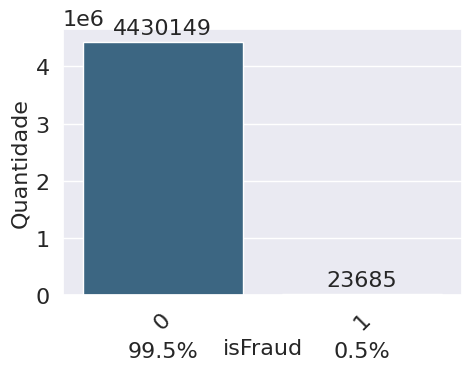

In [26]:
plot_feature_freq(df, 'preds')

## 3.3) Relação entre dados reais e previstos

- Relação simples
- Recall (relação entre VP e FN)
- Precision (relação entre VP e FP)

### 3.3.1) Relação simples

In [27]:
print('Transações fraudulentas reais:', (df.isFraud == 1).sum(), '\nTransações fraudulentas previstas:', (df.preds == 1).sum())

Transações fraudulentas reais: 5749 
Transações fraudulentas previstas: 23685


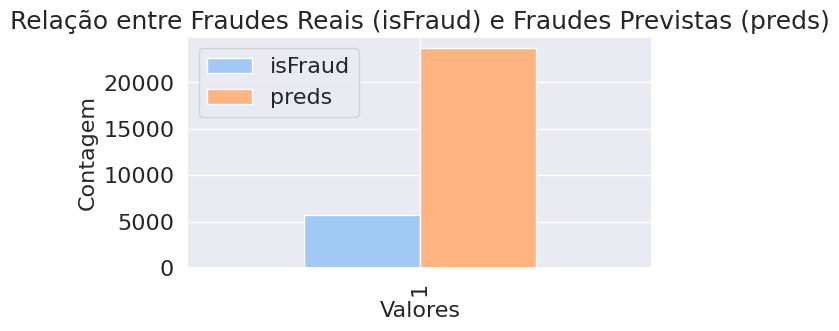

In [28]:
# Filtrando o DataFrame para quando 'isFraud' é igual a 1
is_fraud_1 = df[df['isFraud'] == 1]

# Filtrando o DataFrame para quando 'preds' é igual a 1
preds_1 = df[df['preds'] == 1]

# Contando os valores únicos em cada DataFrame filtrado
is_fraud_counts = is_fraud_1['isFraud'].value_counts()
preds_counts = preds_1['preds'].value_counts()

# Criando um novo DataFrame com os valores únicos contados
relation_df = pd.DataFrame({'isFraud': is_fraud_counts, 'preds': preds_counts})

# Plotando um gráfico de barras para mostrar a relação entre os valores
relation_df.plot(kind='bar', figsize=(6, 3))
plt.xlabel('Valores')
plt.ylabel('Contagem')
plt.title('Relação entre Fraudes Reais (isFraud) e Fraudes Previstas (preds)')
plt.legend(['isFraud', 'preds'])
plt.show()


### 3.3.2) Relação entre Recall e Precisison

- Recall (relação entre VP e FN)
- Precision (relação entre VP e FP)

Tendo em vista a relação estes valores entre Fraudes Reais e Fraudes Previstas, vamos averiguar como o modelo está prevendo os Falsos Positivos e os Falsos Negativos

In [29]:
print(classification_report(df['isFraud'], df['preds']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4448085
           1       0.24      0.99      0.39      5749

    accuracy                           1.00   4453834
   macro avg       0.62      0.99      0.69   4453834
weighted avg       1.00      1.00      1.00   4453834



Analisando a métrica de Recall, podemos observar que o modelo está com:

    - 1 de recall para a classe 0, ou seja, NÃO está prevendo **Falso Negativos** para esta classe 0
    
    - 0.99 de recall para a classe 1, ou seja, ESTÁ prevendo **Falsos Negativos** para esta classe 1



Analisando a métrica de Precision, podemos observar que o modelo está com:

    - 1 de precision para a classe 0, ou seja, NÃO está prevendo **Falso Positivos** para esta classe 0
    
    - 0.24 de precision para a classe 1, ou seja, ESTÁ prevendo **Falsos Positivos** (muitos) para esta classe 1
    
 F1-Score, que média harmônica entre Precision e Recall:
 
     - 1 de F1-Score na classe 1
     - 0.39 de F1-Score na classe 0
    
Na tabela de matriz de confusão vou detalhar mais estes números

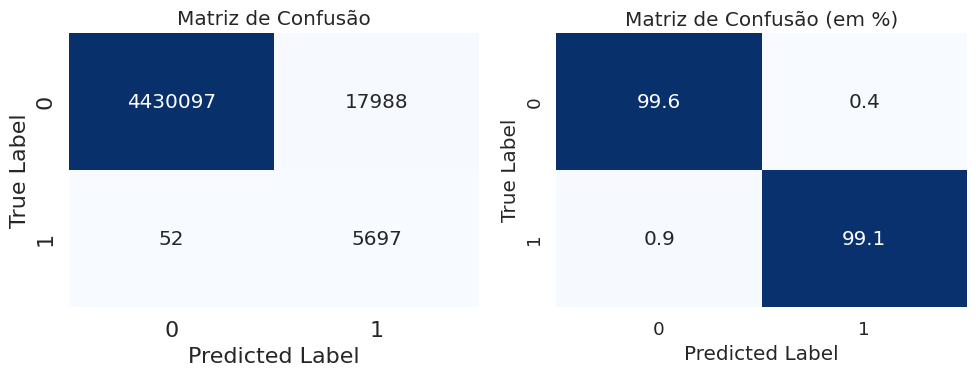

In [30]:
cm_df = pd.DataFrame(confusion_matrix(df['isFraud'], df['preds']),
                     index = sorted(Counter(df['isFraud'])),
                     columns = sorted(Counter(df['preds'])))

# Normalização dos valores da matriz para obter porcentagens
cm_percentage = cm_df.div(cm_df.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 4))

# Plotagem da primeira matriz de confusão
plt.subplot(1, 2, 1)
sns.set(font_scale=1.2)
sns.heatmap(cm_df, annot=True, fmt='.0f', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Plotagem da segunda matriz de confusão (em porcentagem)
plt.subplot(1, 2, 2)
sns.set(font_scale=1.2)
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues', cbar=False)
plt.title('Matriz de Confusão (em %)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.tight_layout()
plt.show()

Na matriz de confusão, podemos observar que, tendo um total de 4.453.834 transações:

Analisando a métrica de Recall, podemos observar que o modelo está prevendo 52 Falsos Negativos (FN na classe 1, de um total de 4.453.834 transações, o que representa um Recall de 0,9814:

    VP / VP + FN
    5697 / 5697 + 52 = 0,99



Analisando a métrica de Precision, podemos observar que o modelo está prevendo 17988 Falsos Positivos (FP na classe 1, de um total de 4.453.834 transações, o que representa um Precision de 0,2587:

    VP / VP + FP
    5697 / 5697 + 17988 = 0,24
    
F1-Score foi de 0,39

    2*((precision * recall) / (precision + recall)
    2*((0,24 * 0,99) / (0,24 + 0,99) = 2*((0,2376) / (1,23)) = 0,3863

# 4) Melhorias possiveis

- Um dos motivos que levou o modelo ter baixa performance com Precision (FP alto) foi a classe **desbalanceada**, onde vemos que:
    - otima performance com uma classe (isFraud = 0), no caso a classe com (bem) mais registros
    - baixa performance com a outra classe (isFraud = 1), com (bem) menos registros
  Sendo assim, o que poderia ter sido feito é excluir registros da classe mais favorecida, tentando chegar num balanço proximo da classe menos favorecida porém pode-se perder dados que poderiam ser vitais no treinamento do modelo.
  O ideal é conseguir mais dados de transações da classe com menos registros (isFraud = 1)

- Testar alternativas de modelos de machine learning

- Tunagem de hiperparametros no base line, como grid search, automl como exemplos

- Trabalhar numa engenharia de features, podendo unir 2 ou mais features num só, depois de extensa analise dos dados e do proprio objetivo do projeto

- Se possivel, obter mais features da fonte de dados

# 5) Conclusão com relação aos resultados do modelo:

O base line deste modelo está prevendo:
    - alta taxa de Falsos Positivos, 17988 transações (Precision Baixo 0,24), ou seja, transações que o modelo considera fraudulentas porém não são reais
    - baixa taxa de Falsos Negativos, 52 transações (Recall Alto 0,99), onde o modelo não previu que era fraude, porém é na realidade
    
A diferença entre a quantidade de transações fraudulentas reais (5749) e as que o modelo previu (23685) é de 17936 transações



# 6) Conclusão com relação ao modelo de negócios

Para um modelo de detecção de fraudes, encontrar um equilíbrio entre falsos positivos e falsos negativos é crucial, mas a importância pode depender do contexto e das consequências de cada tipo de erro.

- Falsos Positivos: São casos em que o modelo identifica erroneamente uma transação ou evento como fraude quando na realidade não é. Isso pode resultar em inconveniência para os clientes legítimos, bloqueio de transações válidas e perda de confiança no sistema.

- Falsos Negativos: São casos em que o modelo deixa passar uma transação fraudulenta, classificando-a como legítima. Isso pode resultar em perdas financeiras significativas para a instituição e para os clientes afetados, além de impactar a reputação e credibilidade do sistema.

Em geral, para sistemas de detecção de fraudes, o objetivo é minimizar tanto os falsos positivos quanto os falsos negativos. No entanto, dependendo do contexto específico e dos recursos disponíveis para lidar com cada tipo de erro, a prioridade pode variar:

- Se os recursos para revisar e lidar com casos suspeitos forem limitados, é fundamental minimizar os falsos positivos para reduzir o tempo e os custos associados à revisão manual de transações legítimas.

- Se as consequências financeiras das fraudes forem muito altas, pode ser mais crítico minimizar os falsos negativos para evitar perdas substanciais.

O ideal é buscar um equilíbrio, ajustando o modelo e suas métricas de avaliação para encontrar um ponto ótimo que reduza ambos os tipos de erro, considerando as implicações práticas e os custos associados a cada tipo de equívoco no contexto específico da detecção de fraudes.